# Rotini

**Background**

We prepare a Hall strip and then watch the free evolution of a quasi-1D interacting BEC under a gauge field with no external scalar potential in the rotating frame.

In [1]:
import sys, os, re
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from tqdm.notebook import tqdm
from scipy.ndimage import rotate as rotate_image
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from skimage.filters import gaussian as gaussblur
from scipy.optimize import curve_fit
from PIL import Image
import time
import h5py
import pandas as pd
import warnings
from condensate import Wavefunction, Environment, hbar
%matplotlib inline



SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def gauss(x,x0,a,s): return a*np.exp(- (x-x0) **2 / (2*s**2))

def satexp(t, tau,a): return (3.31+a*np.exp(-t/tau))

def rotate_crop(array, viewx=200, viewy=350, angle=0):
    """ Rotate and crop a 2d array """
    s = np.shape(array)
    rotated = rotate_image(array, angle, reshape=False)
    cropped = rotated[(s[0]-viewy)//2 : (s[0]+viewy)//2 , (s[1]-viewx)//2 : (s[1]+viewx)//2 ]
    return cropped

def find_angle(ncrop):
    xsize = len(ncrop)
    xx = np.linspace(-10, 10, xsize)
    yy = np.linspace(-10, 10, xsize)
    xx, yy = np.meshgrid(xx, yy)

    # Calculate the moment of inertia tensor
    Ixx = np.sum(ncrop*yy*yy)
    Iyy = np.sum(ncrop*xx*xx)
    Ixy = np.sum(ncrop*xx*yy)
    Iyx = Ixy
    I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
    evals, evecs = np.linalg.eig(I)
    iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)
    return iangle


## Prepare groundstate

In [2]:
omega   = 2*np.pi*10
epsilon = 0.2
dt = 1e-5
fov = 350e-6
DIM=512

e = Environment(DIM=DIM, fov=fov, N=1e6)
e.harmonic_potential(omega=omega, epsilon=epsilon)


            Running condensate on 512x512 grid with:
            atom number: 1e+06 
            mass:        3.80e-26
        


In [3]:
groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=3e8, dt=dt, steps=4000)

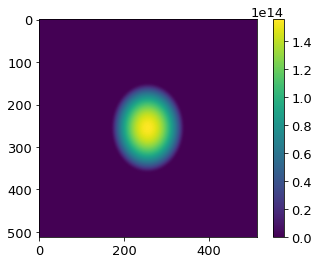

1000000.0


In [133]:
groundstate.show_density()
print(np.round(np.sum(groundstate.density) * ((fov/DIM)**2)))

## Spin up

In [35]:
def rotation_freq_simple(timestep, whirrTime=30000, whirrMax=omega):
    tanh =  omega * 1.002 * np.tanh(3.46 * timestep / whirrTime)
    return np.min([whirrMax,tanh])

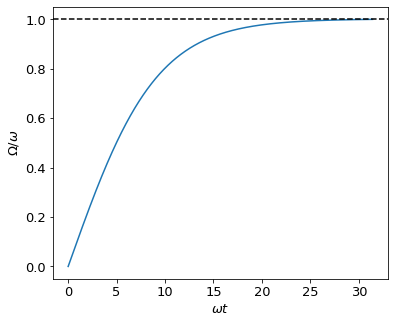

In [36]:
whirrMax = omega
steps = 50000
whirrtime = 50000
times = np.arange(steps)
Omega = [rotation_freq_simple(t, whirrTime=whirrtime) for t in times]

plt.figure(figsize=(6,5))
plt.plot(omega*dt*times, np.array(Omega)/omega)
plt.axhline(Omega[-1]/omega,ls='--',c='k')
plt.xlabel(r'$\omega t$')
plt.ylabel(r'$\Omega/\omega$')
plt.show()

In [37]:
hallstrip = deepcopy(groundstate)

In [38]:
hallenv = hallstrip.env
hallenv.rotating_frame(omegaR=Omega)
hallenv.absorbing_boundaries(strength=1, radius=1.2*e.fov/2)

hallstrip.evolve(dt=dt, steps=steps, cooling=0.0)

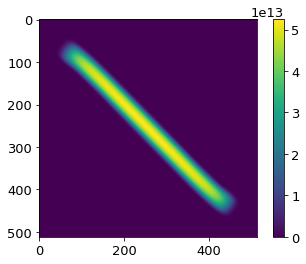

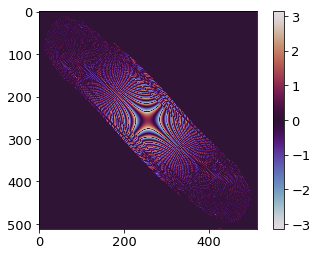

In [39]:
hallstrip.show_density()
hallstrip.show_phase()

In [277]:
startstrip = deepcopy(hallstrip)

In [105]:
steps=5000
startstrip.env.rotating_frame(omegaR=omega*np.ones(steps))
# startstrip.env.harmonic_potential(omega=omega, epsilon=0.05)
startstrip.evolve(steps=steps, cooling=0.0, dt=2e-5)

## Calibrate starting widths

In [13]:
# Set some processing parameters
viewx = 150
viewy = 150
dx = fov/512
mass = 3.8e-26
lb = np.sqrt(hbar / (2*mass *omega))
y  = dx * (np.arange(viewy) - viewy//2)

def gauss(x,x0,a,s): return a*np.exp(- (x-x0) **2 / (2*s**2))

def satexp(t, tau,a): return (3.31+a*np.exp(-t/tau))

def rotate_crop(array, viewx=200, viewy=350, angle=0):
    """ Rotate and crop a 2d array """
    s = np.shape(array)
    rotated = rotate_image(array, angle, reshape=False)
    cropped = rotated[(s[0]-viewy)//2 : (s[0]+viewy)//2 , (s[1]-viewx)//2 : (s[1]+viewx)//2 ]
    return cropped

def find_angle(ncrop):
    xsize = len(ncrop)
    xx = np.linspace(-10, 10, xsize)
    yy = np.linspace(-10, 10, xsize)
    xx, yy = np.meshgrid(xx, yy)

    # Calculate the moment of inertia tensor
    Ixx = np.sum(ncrop*yy*yy)
    Iyy = np.sum(ncrop*xx*xx)
    Ixy = np.sum(ncrop*xx*yy)
    Iyx = Ixy
    I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
    evals, evecs = np.linalg.eig(I)
    iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)
    return iangle

def find_width(density, window=200, plot=False):
    cloud = density/1e20
    cloud = rotate_crop(cloud, viewx=window, viewy=window, angle=90+np.real(find_angle(cloud)))
    x  = dx * (np.arange(window) - window//2)
    xprofile = np.sum(cloud, axis=0)
    gaussfit,_ = curve_fit(gauss, x, xprofile, [0, np.max(xprofile), 6e-6])
    if plot: 
        f,a = plt.subplots(ncols=2)
        a[0].imshow(cloud)
        a[1].plot(x,xprofile)
        a[1].plot(x,gauss(x,*gaussfit))
        a[1].set_aspect(1./a[1].get_data_ratio())
        plt.tight_layout()
        plt.show()
    return gaussfit[2]

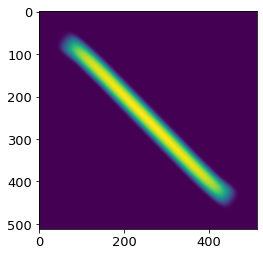

In [280]:
plt.imshow(startstrip.density)

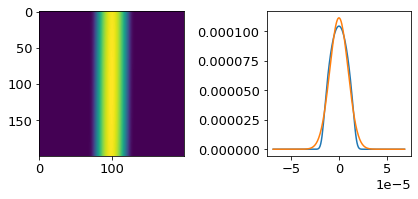

2.8519368611497025


In [281]:
width = find_width(startstrip.density, plot=True)
print(np.sqrt(2) * width / lb)

In [291]:
170*300

51000

In [292]:
# plot the widths for a bunch of times
rlbs = []
steps = 170
frames = 300
times = np.cumsum([0] + [steps] * frames)
startstrip = deepcopy(hallstrip)
width = find_width(startstrip.density, plot=False)
rlbs.append(np.sqrt(2) * width/lb)
for time in tqdm(times[1:]):
    startstrip.env.rotating_frame(omegaR=omega*np.ones(steps))
    startstrip.evolve(steps=steps, cooling=0.0, dt=2e-5)
    width = find_width(startstrip.density, plot=False)
    rlbs.append(np.sqrt(2) * width/lb)
    
tosave = np.vstack([times,rlbs])
np.savetxt('data/stripwidths_sep14_2020.csv', tosave)

In [320]:
times, rlbs = np.genfromtxt('data/stripwidths_sep14_2020.csv')
smoothed = savgol_filter(rlbs,53,5)
widths_interpolated = interp1d(times,smoothed)

def expfit(t,tau,amp): return 1+amp*np.exp(-t/tau)
f,_ = curve_fit(expfit, times, rlbs, [1e4,2])

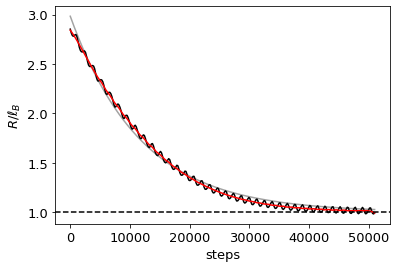

In [321]:
plt.plot(times, np.array(rlbs),'k-')
plt.plot(times, expfit(times, *f), '-', c=[0.1,0.1,0.1,0.4])
plt.plot(times, widths_interpolated(times), 'r')
plt.axhline(1,ls='--', c='k')
plt.xlabel('steps')
plt.ylabel('$R/\ell_B$')
plt.show()

## Make Rotini

In [107]:
rotini = deepcopy(startstrip)
# rotini.env.spoon['type'] = 'mouse'

In [108]:
noise = (0.j)*np.zeros((DIM,DIM))
for i in range(DIM):
    for j in range(DIM):
        noise[i,j]= np.exp(0.15 * 1.j * 2*np.pi * (0.5-np.random.rand()))

rotini.Psi *= noise

In [109]:
steps = 10000
rotini.env.harmonic_potential(omega=omega, epsilon=0.0)
rotini.env.rotating_frame(omegaR=[omega]*steps)
rotini.evolve(steps=steps, cooling=0.0, dt=4e-5)

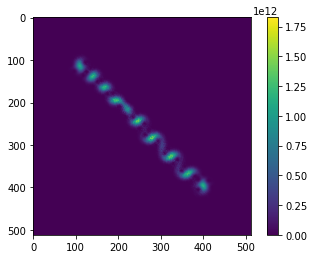

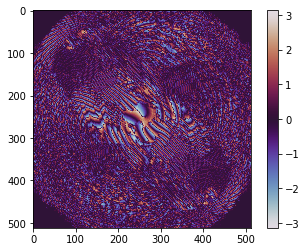

In [170]:
rotini.show_density()
rotini.show_phase()

# Find vortices

In [8]:
# Functions
warnings.simplefilter("ignore")

def phase_vortex_finder(inputPsi,
                        rigidphase=14,
                        blursigma=10,
                        blurthreshold=0.5,
                        returnPhase=False,
                        debug=False):
    '''
    Finds vortices using the phase. Steps:
    1) cancel the xy phase
    2) blur the density to make a blurmask
    3) find points where the curl of the velocity field (dphi) is nonzero, within the blurmask
    '''
    test = inputPsi.copy() / 1e3
    x = np.linspace(-5,5,DIM)
    xx, yy = np.meshgrid(x, x)
    phase = (xx + yy)*(xx- yy)
    test *= np.exp(1j * rigidphase * phase)
    
    blurmask = gaussblur(np.abs(test), sigma=blursigma) > blurthreshold
    
    if debug:
        f,axarr = plt.subplots(figsize=(12,5), ncols=2)
        im = axarr[0].imshow(np.abs(test) * blurmask)
        plt.colorbar(im, ax=axarr[0])
        axarr[1].imshow(np.angle(test) * blurmask, cmap='bwr')
        plt.show()
        
    vorts = np.zeros((DIM,DIM))

    for i in range(DIM-1):
        for j in range(DIM-1):
            if blurmask[i,j]:
                g = np.zeros(4)
                dphi = np.zeros(4)
                g[0] = (test[i,j]     / test[i+1,j])   * (np.abs(test[i+1, j])   / np.abs(test[i,j]))
                g[1] = (test[i+1,j]   / test[i+1,j+1]) * (np.abs(test[i+1, j+1]) / np.abs(test[i+1,j]))
                g[2] = (test[i+1,j+1] / test[i,j+1])   * (np.abs(test[i, j+1])   / np.abs(test[i+1,j+1]))
                g[3] = (test[i,j+1]   / test[i,j])     * (np.abs(test[i, j])     / np.abs(test[i,j+1]))
                for k in range(4):
                    dphi[k] = np.angle(g[k])
                total = sum(dphi)
                vorts[i,j] = total / 2*np.pi
                
    if returnPhase:
        return vorts, np.angle(test) * blurmask
    else:
        return vorts
    
def make_frame(cloud, savefig=None, plot=False):
    '''
    Plot a frame of the movie
    '''
    density = np.abs(cloud)
    smoothRotini = deepcopy(rotini)
    relaxsteps = 10
    smoothRotini.Psi = np.complex128(cloud.copy())
    smoothRotini.env.rotating_frame(omegaR=[omega]*relaxsteps)
    smoothRotini.env.absorbing_boundaries(strength=10, radius=1.2*e.fov/2)
    smoothRotini.relax(steps=relaxsteps,dt=5e-5, vmax=1e8)
    vorts, phase = phase_vortex_finder(smoothRotini.Psi,
                                       blurthreshold=4,
                                       rigidphase=13.6,
                                   debug=False, returnPhase=True)
    f, axarr = plt.subplots(figsize=(10,6), ncols=2)
    axarr[0].imshow(0.3*density/np.max(density) + vorts, vmax=.35,vmin=0.03,cmap='inferno')
    axarr[0].axis('off')
    axarr[1].imshow(phase, cmap='bwr')
    axarr[1].axis('off')
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig, dpi=150)
    if not plot: plt.close()

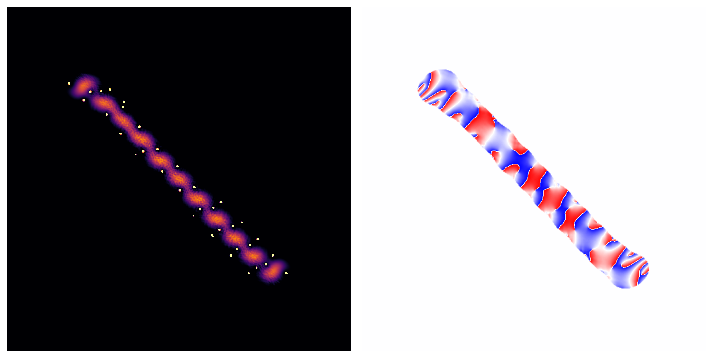

In [209]:
make_frame(rotini.Psi.copy(), plot=True, savefig=f'data/testTracked.jpg')

## Make a rotini movie with vortices

In [46]:
def noiseMaker(amp=0.15):
    noise = (0.j)*np.zeros((DIM,DIM))
    for i in range(DIM):
        for j in range(DIM):
            noise[i,j]= np.exp(amp * 1.j * 2*np.pi * (0.5-np.random.rand()))
    return noise


# generate data        
dt = 4e-5

def compute_rotini(startStrip, runTime=40000, frames=7,
                   dsname='rotini', datafile='data/rotini.hdf5'):
    
    rotini = deepcopy(startStrip)
    rotini.env.harmonic_potential(omega=omega, epsilon=0.0)
    times = [runTime // frames] * frames
    
    with h5py.File(datafile, 'w') as f:
        dset = f.create_dataset(dsname, (frames+1, DIM, DIM), dtype='complex64')
        dset[0] = np.complex64(rotini.Psi.copy())
        dset.attrs['times'] = np.cumsum(times)
        dset.attrs['dt'] = dt
        i=1
    
        for steps in tqdm(times, leave=False):
            rotini.env.rotating_frame(omegaR=[omega]*steps)
            rotini.evolve(steps=steps, cooling=0.0, dt=dt)
            dset[i] = np.complex64(rotini.Psi.copy())
            i += 1
        

# squeezeStrip = deepcopy(hallstrip)
# steps = 50000
# squeezeStrip.env.rotating_frame(omegaR=omega*np.ones(steps))
# squeezeStrip.evolve(steps=steps, cooling=0.0, dt=2e-5) 

# startStrip = deepcopy(squeezeStrip)
# startStrip.Psi *= noiseMaker()
# compute_rotini(startStrip=startStrip, runTime=200000, frames=900,
#                   dsname=f'rotini', datafile='data/rotiniMovieLLL.hdf5')
    

In [211]:
with h5py.File('data/rotiniMovieLLL.hdf5', 'r') as f:
    dset = f['rotini']
    for i in tqdm(range(len(dset))):
        cloud = dset[i]
        make_frame(cloud, plot=False, savefig=f'figures/rotini1d/rotiniVortexTrackedLLL/rotini_{i:03d}.jpg')

In [212]:
!ffmpeg -framerate 25 -i figures/rotini1d/rotiniVortexTrackedLLL/rotini_%03d.jpg -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

# Growth rates

## Make data

Data notes:
- Regular timestamps
- 10 R/Lb: 3 to 1.03
- total length: ideally around 15-20 T
- frames: 100
- reps: 5
- save just the density for now

In [122]:
def noiseMaker(amp=0.15):
    noise = (0.j)*np.zeros((DIM,DIM))
    for i in range(DIM):
        for j in range(DIM):
            noise[i,j]= np.exp(amp * 1.j * 2*np.pi * (0.5-np.random.rand()))
    return noise


# generate data        
dt = 4e-5

def compute_rotini_growth(startStrip, squeezes, frames=100, noises=5, runTime=50000,
                   dsname='rotini', datafile='data/rotini_growth_Sep_15_2020.hdf5'):
    
    times = [runTime // frames] * frames
    
    with h5py.File(datafile, 'w') as f:
        
        for squeeze in tqdm(squeezes):
            squeezeStrip = deepcopy(startStrip)
            squeezeStrip.env.rotating_frame(omegaR=omega*np.ones(squeeze))
            squeezeStrip.evolve(steps=squeeze, cooling=0.0, dt=2e-5) 

            for noisei in tqdm(range(noises), leave=False):
                rotini = deepcopy(squeezeStrip)
                rotini.env.harmonic_potential(omega=omega, epsilon=0.0)
                rotini.Psi *= noiseMaker()

                dset = f.create_dataset(dsname + f'_sq_{squeeze}_noiserep_{noisei}',
                                        (frames+1, DIM, DIM), dtype='float32')
                dset[0] = np.float32(rotini.density.copy())
                dset.attrs['times'] = np.cumsum(times)
                dset.attrs['dt'] = dt
                dset.attrs['squeeze'] = squeeze
                i=1

                for steps in tqdm(times, leave=False):
                    rotini.env.rotating_frame(omegaR=[omega]*steps)
                    rotini.evolve(steps=steps, cooling=0.0, dt=dt)
                    dset[i] = np.float32(rotini.density.copy())
                    i += 1


startStrip = deepcopy(hallstrip)
squeezes = [10,5000,10000,15000,20000,25000,30000,35000,40000,45000]

compute_rotini_growth(startStrip=startStrip, squeezes=squeezes)
    

## Process growth rates

processing notes:
- get 1D profiles calibrated
- Get S(k,t)
- Fit with Cosh(2*rate * t)

In [316]:
dx = fov/DIM
window = 400
x  = dx * (np.arange(window) - window//2)
dk = 1/(window * dx)
k = dk * np.arange(window)
mass = 3.8e-26
lb = np.sqrt(hbar / (2*mass *omega))
klb = lb * k * (2*np.pi)

def process_growth(density, plot=False):
    cloud = rotate_crop(density, viewx=window, viewy=window, angle=43)
    cloud *= (fov/DIM)**2  # convert density (atoms / m^2) to Atoms per pixel (atoms / pixel**2)
    xprofile = np.sum(cloud, axis=0) # calculate atoms per 1D pixel (sum along transverse)
    sk = (abs(np.fft.fft(xprofile - np.mean(xprofile)))) **2  / np.sum(xprofile) # the real s(k)
#     gaussfit,_ = curve_fit(gauss, x, xprofile, [0, np.max(xprofile), 6e-6])
    if plot: 
        f,a = plt.subplots(figsize=(12,8),ncols=3)
        a[0].imshow(np.rot90(cloud))
        a[0].set(title=f'N={int(np.sum(cloud))}')
        a[1].plot(1e6*x,xprofile)
        a[1].set(title=f'N={int(np.sum(xprofile))}')
        a[1].set_aspect(1./a[1].get_data_ratio())
        a[2].plot(klb,sk)
        a[2].set(xlim = [0,3])
        a[2].set_aspect(1./a[2].get_data_ratio())
#         a[2].plot(x,gauss(x,*gaussfit))
        plt.tight_layout()
        plt.show()
    return sk

#fitting 

@np.vectorize
def coshfuncsat(t,rate,amp, tsat):
    return min(np.log(amp*np.cosh(2*rate*t)),np.log(amp*np.cosh(2*rate*tsat)))

def coshfunc(t,rate,amp):
    return np.log(amp*np.cosh(2*rate*t))

4521.94441216


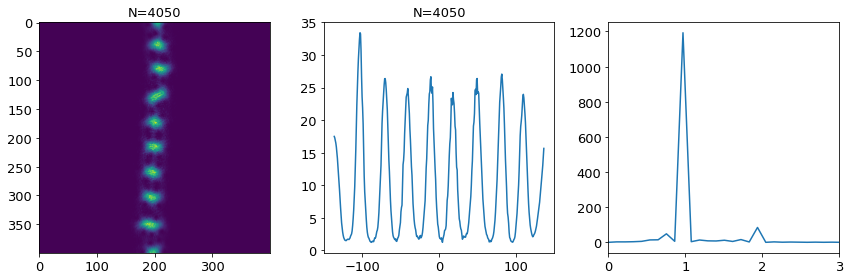

In [412]:
# Do a sample
with h5py.File('data/rotini_growth_Sep_14_2020.hdf5', 'r') as f:
    dset = f['rotini_sq_35000_noiserep_1']
    times = dset.attrs['dt'] * dset.attrs['times'] * omega / (2*np.pi)
    i=100
    cloud = dset[i]
    print(np.sum(cloud)* (fov/DIM)**2)
    sk = process_growth(cloud, plot=True)

In [210]:
# Extract samples and structure factors
growth_list = []
samples_select = np.arange(0,100,9)

with h5py.File('data/rotini_growth_Sep_14_2020.hdf5', 'r') as f:
    for key in tqdm(f.keys()):
        dset = f[key]
        results = {}
        results['name'] = key
        results['squeezetime'] = dset.attrs['squeeze']
        
        # Produce the samples
        samples=[]
        for i in tqdm(samples_select, leave=False, desc='samples'):
            cloud = rotate_crop(dset[i], viewx=window, viewy=150, angle=45)
            samples.append(cloud)
        results['samples'] = np.rot90(np.vstack(samples))
        
        # Produce the structure factors
        sks = []
        for cloud in tqdm(dset, leave=False, desc='structure factors'):
            sk = process_growth(cloud, plot=False)
            sks.append(sk)
        results['sk'] = np.array(sks)
        
        growth_list.append(results)

growthdf = pd.DataFrame(growth_list)
growthdf.sort_values(by='squeezetime', inplace=True)

In [296]:
# Evaluate widths
growthdf['widths'] = widths_interpolated(growthdf['squeezetime'])

In [373]:
# Evaluate structure factor peak positions (for later peak growth estimation)
growthdf['finalsk'] = None
growthdf['skpeakfit'] = None
for i,r in growthdf.iterrows():
    finalsk = np.mean(r.sk[90:], axis=0)
    growthdf.at[i,'skpeakfit'],_ = curve_fit(gauss, klb, finalsk, [0.8, np.max(finalsk), 0.2])
    growthdf.at[i,'finalsk'] = finalsk
    
        

(0.9, 3.7)

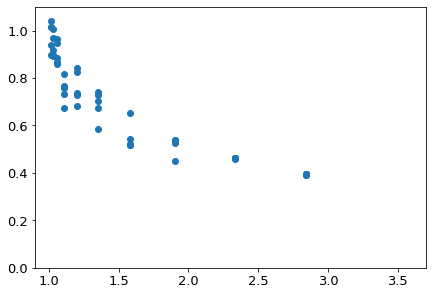

In [386]:
plt.subplots(figsize=(7,4.8))
plt.plot(growthdf.widths, [x[0] for x in growthdf.skpeakfit],'o')
plt.ylim([0,1.1])
plt.xlim([0.9,3.7])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


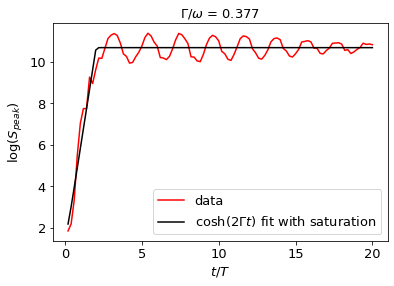

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


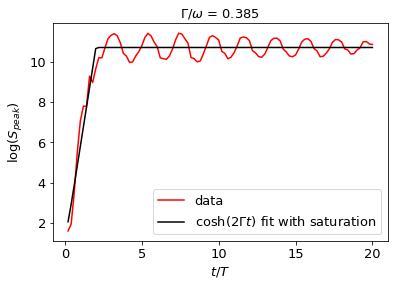

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


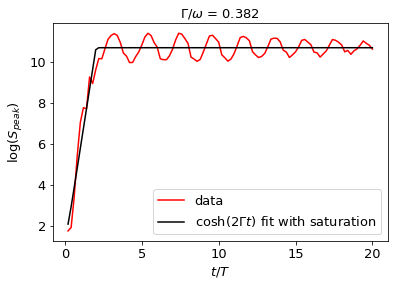

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


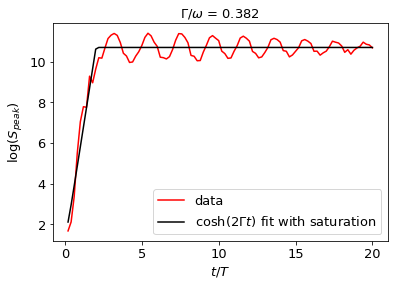

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


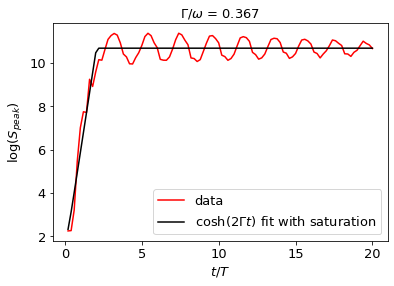

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


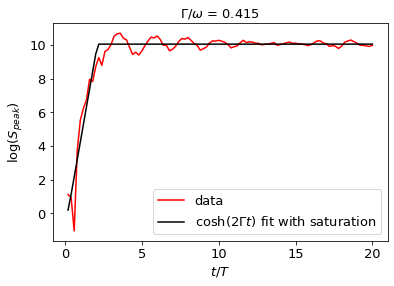

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


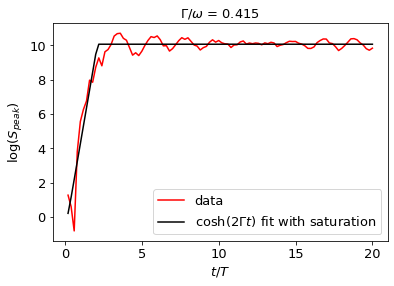

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


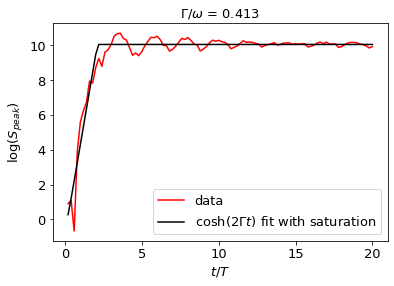

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


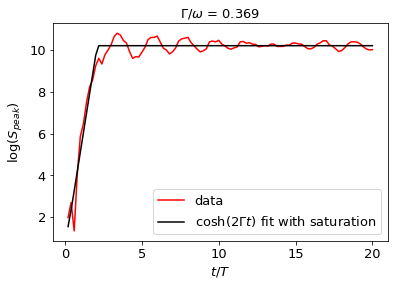

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


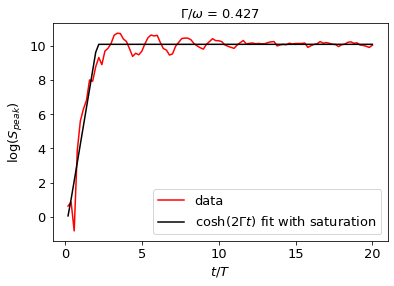

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


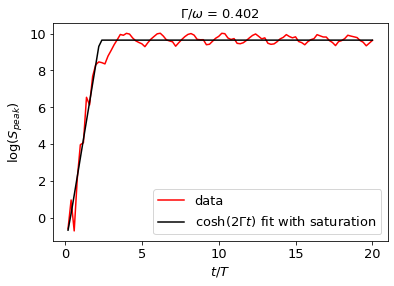

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


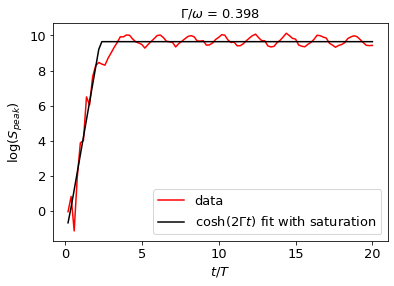

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


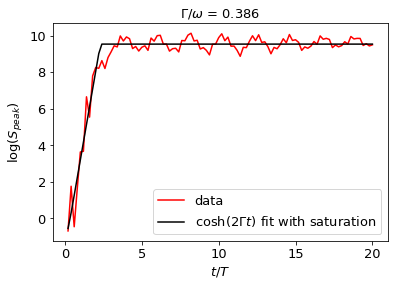

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


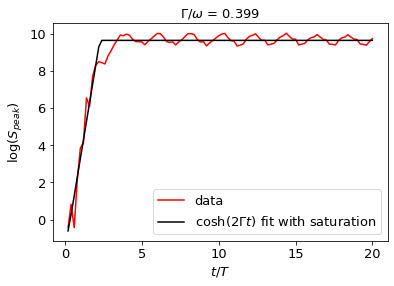

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


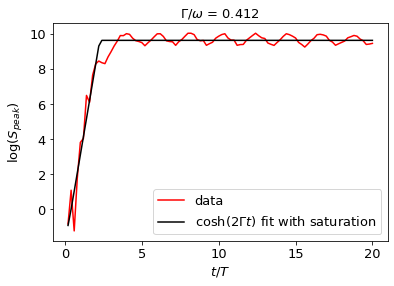

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


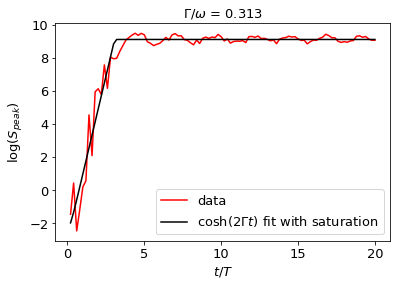

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


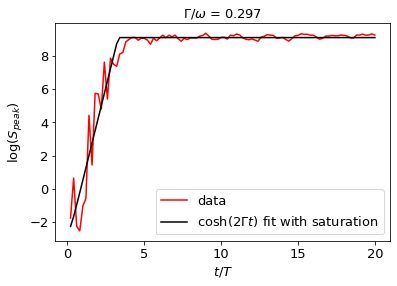

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


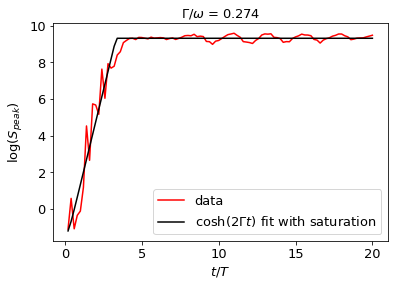

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


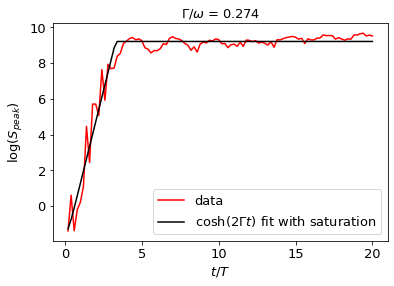

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


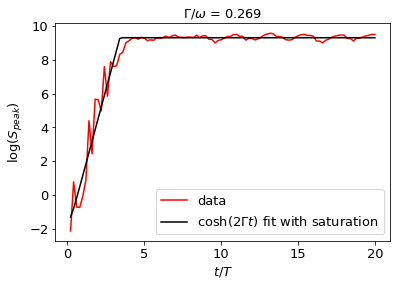

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


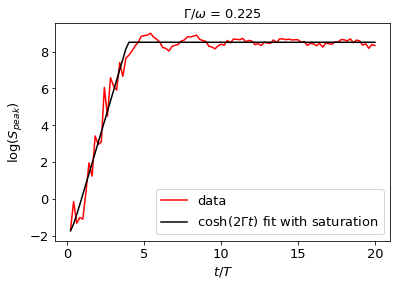

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


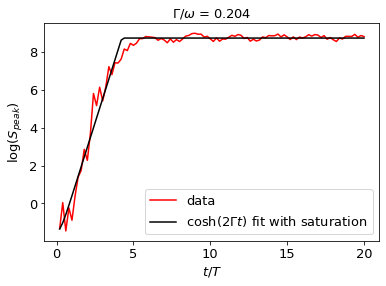

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


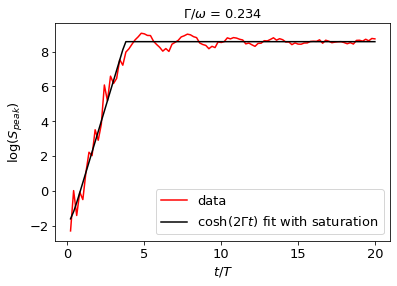

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


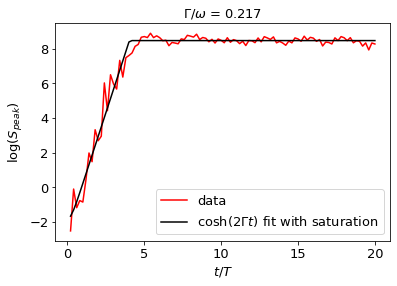

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


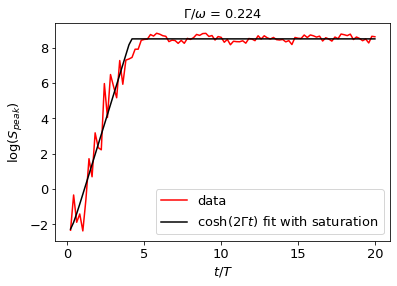

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


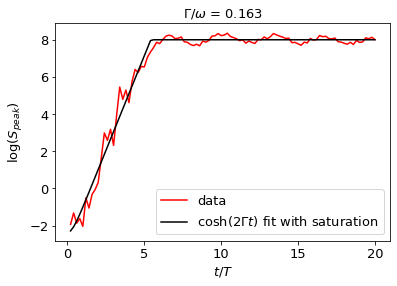

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


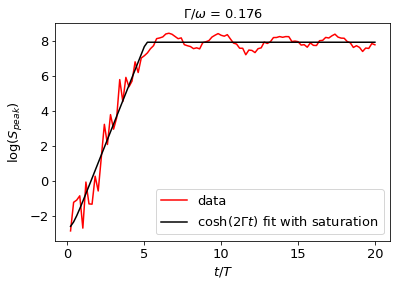

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


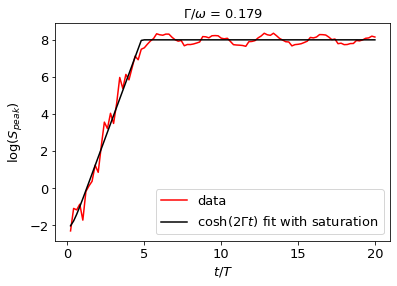

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


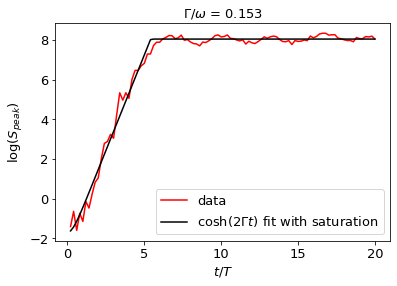

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


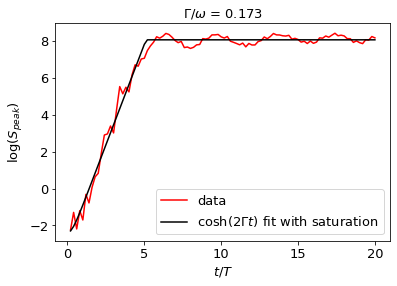

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


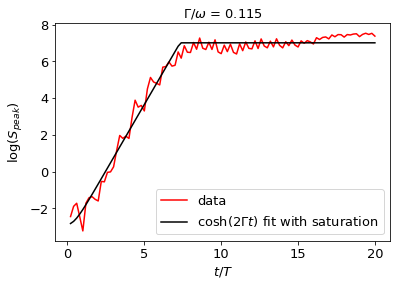

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


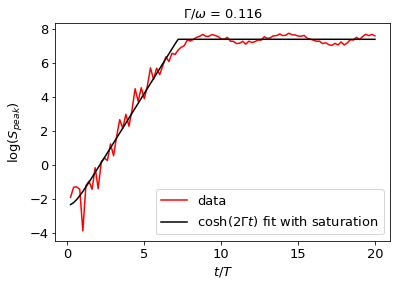

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


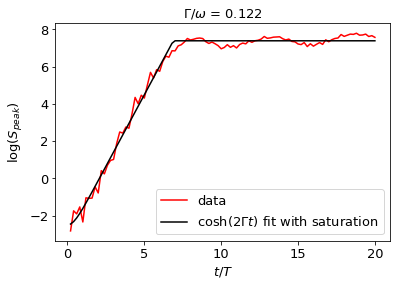

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


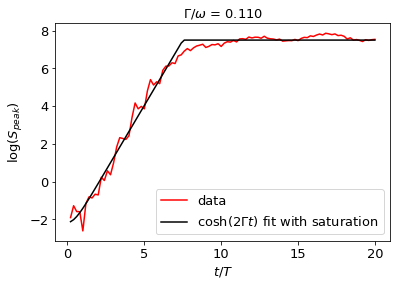

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


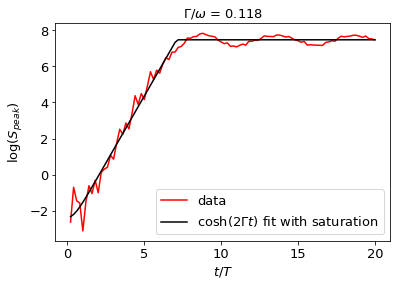

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


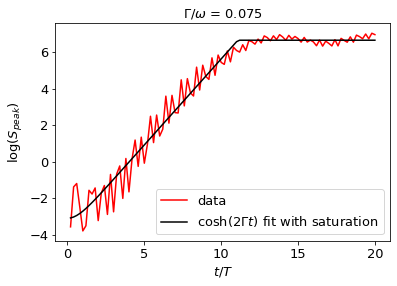

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


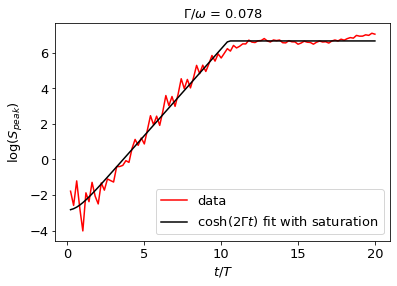

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


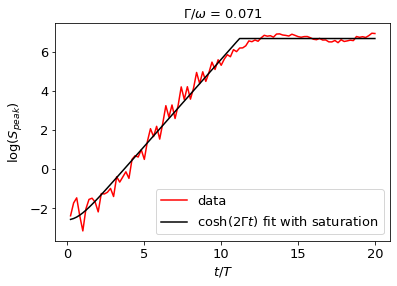

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


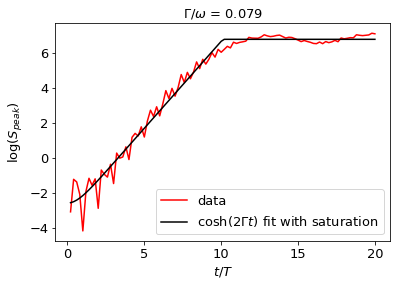

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


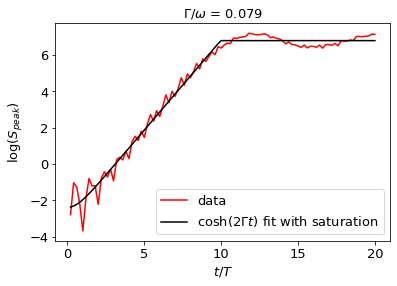

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


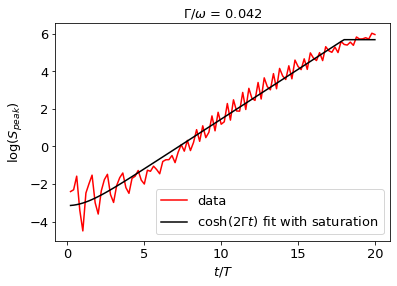

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


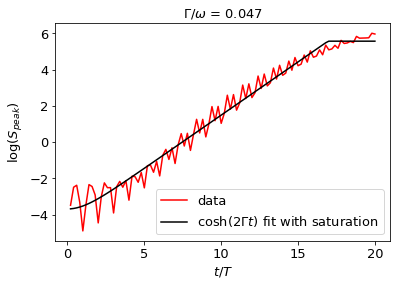

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


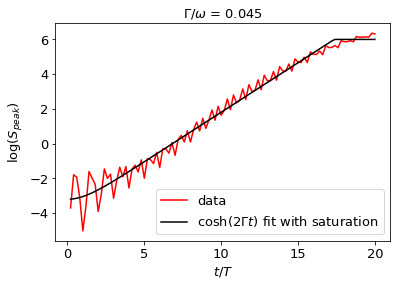

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


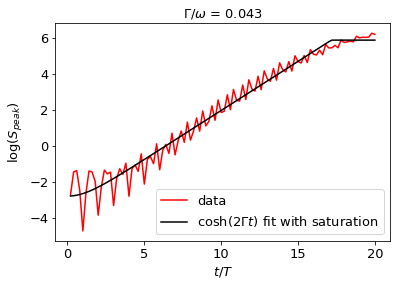

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


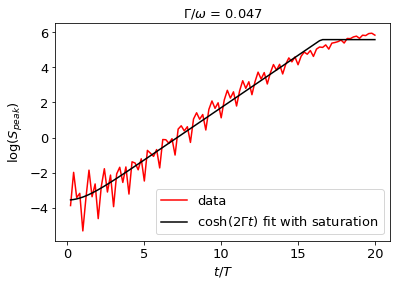

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


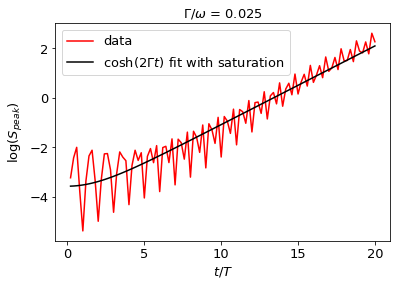

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


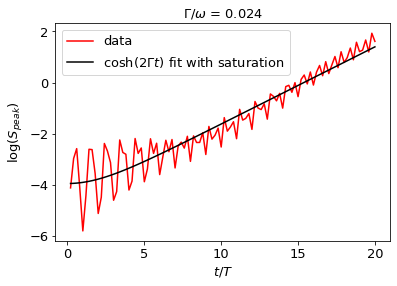

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


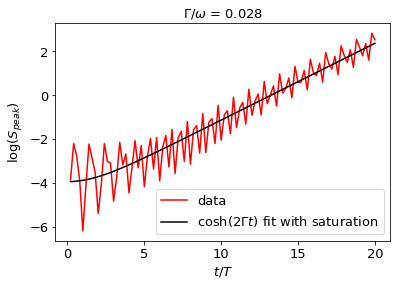

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


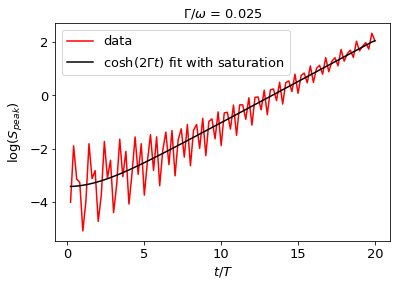

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


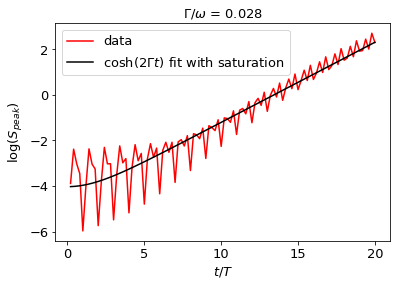

In [419]:
# Evaluate growth rates

growthdf['peakgrowth'] = None
growthdf['peakgrowthfit'] = None

for i,r in growthdf.iterrows():
    peakpos = growthdf.at[i,'skpeakfit'][0]
    kmask = [k>0.7*peakpos and k < 1.3*peakpos for k in klb]
    growth = np.sum(r.sk[1:, kmask], axis=1)
    xs = times
    ys = np.log(growth)
    guess= [1,200000,5]
    f,e = curve_fit(coshfuncsat, xs, ys, guess)
    
    growthdf.at[i, 'peakgrowth'] = growth
    growthdf.at[i, 'peakgrowthfit'] = f
    
    plt.plot(xs,ys,'r', label='data')
    plt.plot(xs, coshfuncsat(xs,*f),'k', label='$\cosh(2\Gamma t)$ fit with saturation')
    plt.xlabel('$t/T$')
    plt.ylabel('$\log(S_{peak})$')
    plt.title(f'$\Gamma/\omega$ = {f[0]/(2*np.pi):.3f}')
    plt.legend()
    plt.show()
    

(1.0, 4.0)

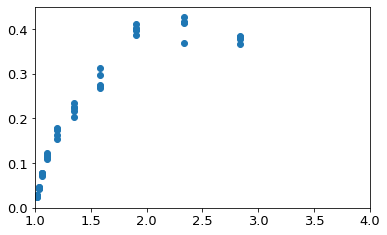

In [427]:
rates = [r[0]/(2*np.pi) for r in growthdf['peakgrowthfit']]
plt.subplots(figsize=(6,3.7))
plt.plot(growthdf['widths'], rates,'o')
plt.ylim([0,0.45])
plt.xlim([1,4])

In [429]:
# save data
growthsave = np.vstack([growthdf['widths'], rates])
lengthscalesave = np.vstack([growthdf.widths, [x[0] for x in growthdf.skpeakfit]])

np.savetxt('data/rotinigrowths_sep14_2020.csv', tosave)

(0.0, 3.0)

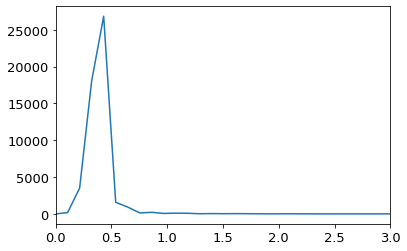

In [322]:
plt.plot(klb, np.mean(growthdf.iloc[0].sk[90:],axis=0))
plt.xlim([0,3])

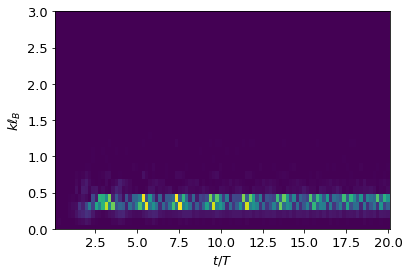

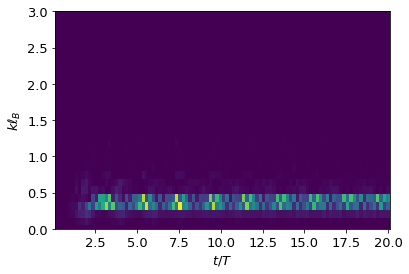

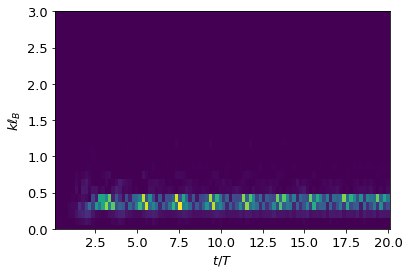

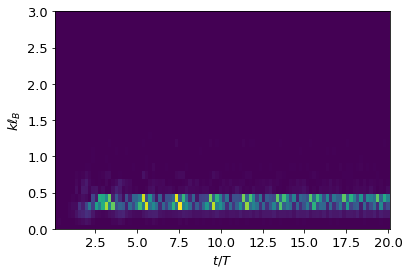

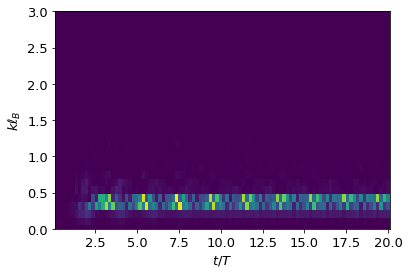

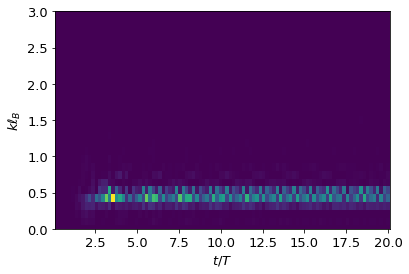

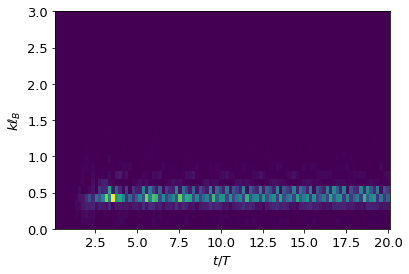

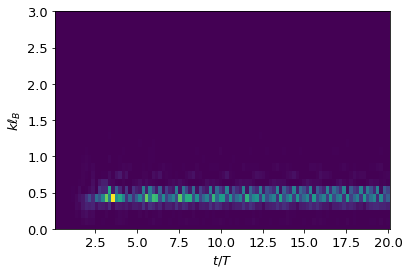

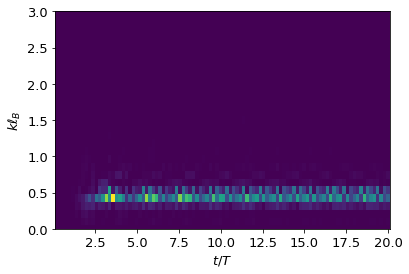

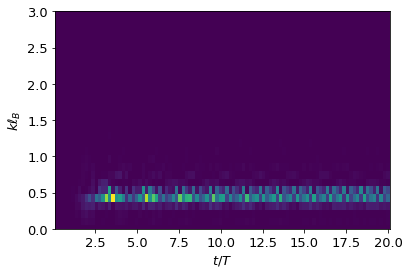

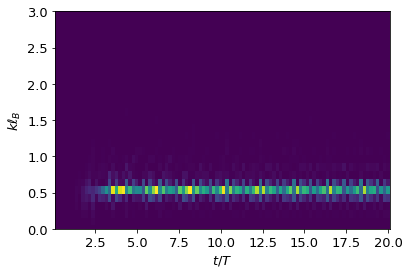

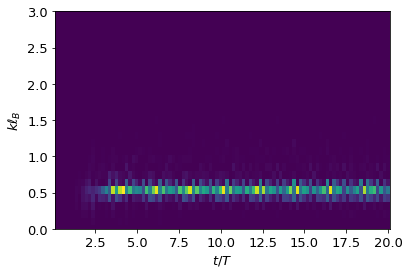

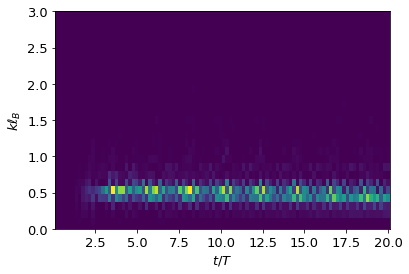

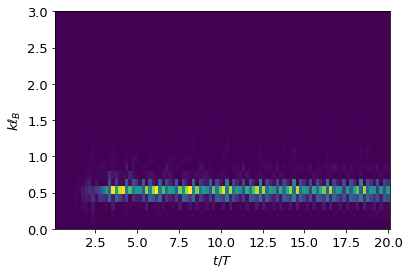

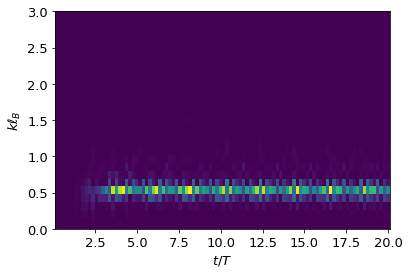

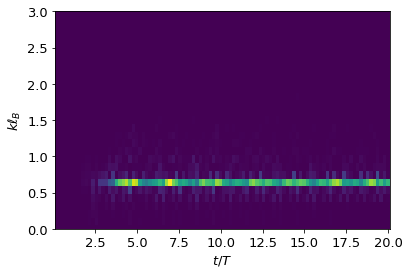

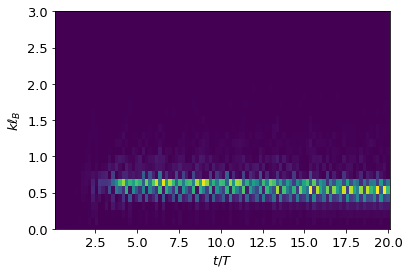

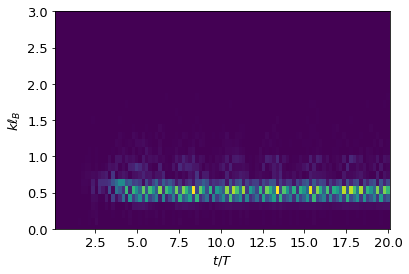

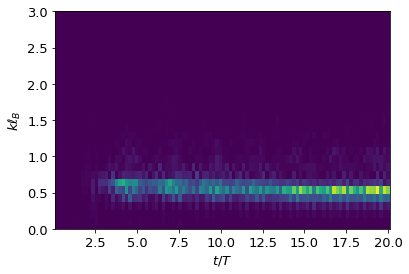

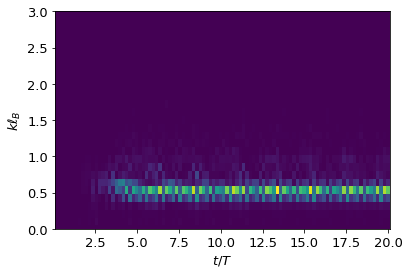

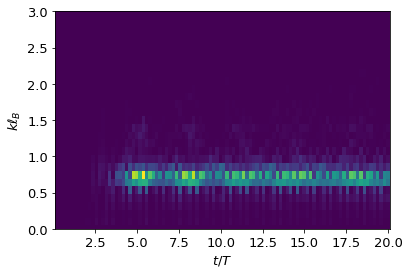

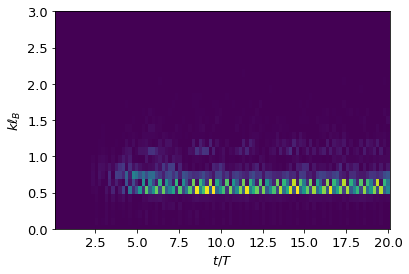

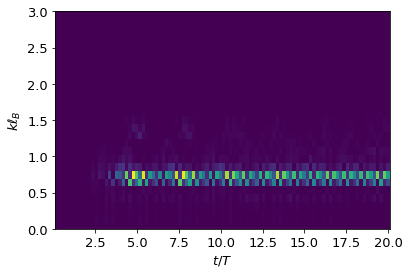

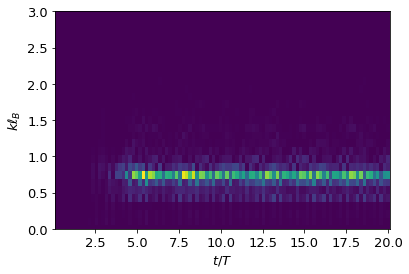

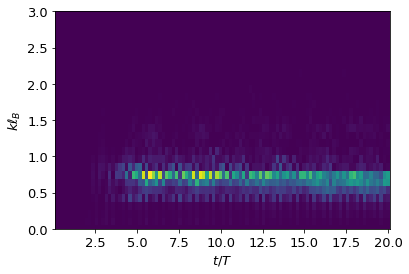

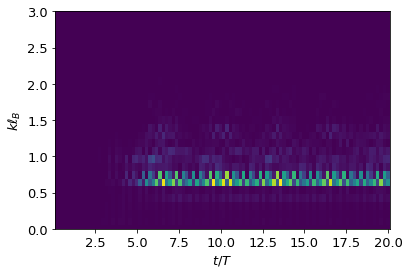

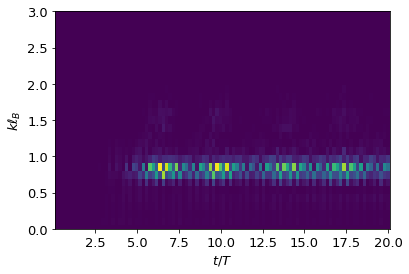

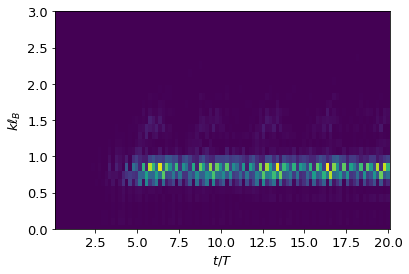

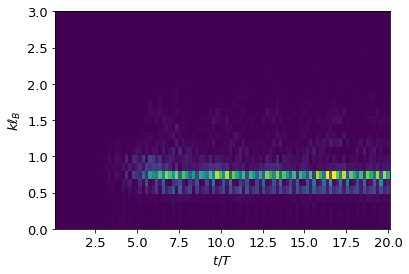

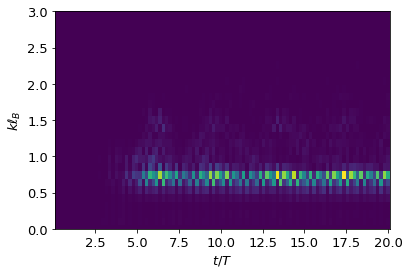

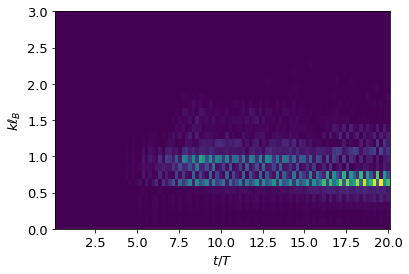

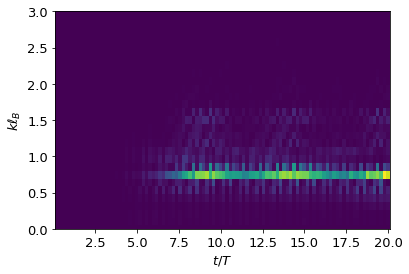

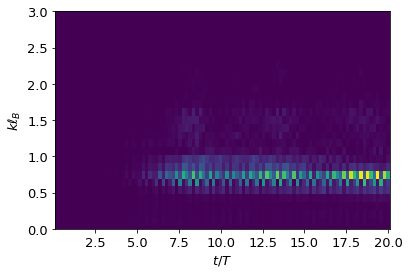

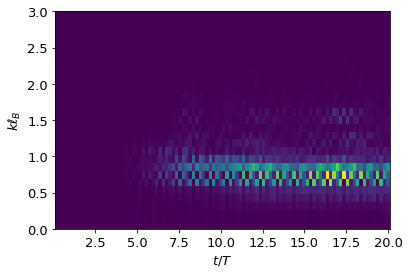

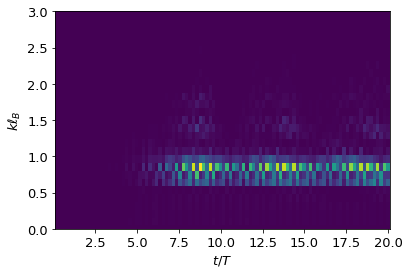

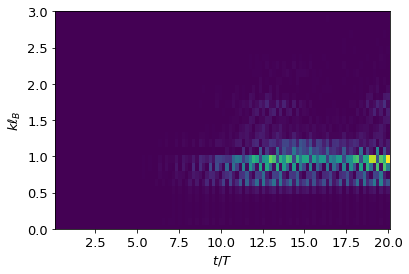

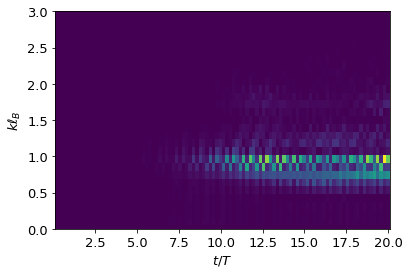

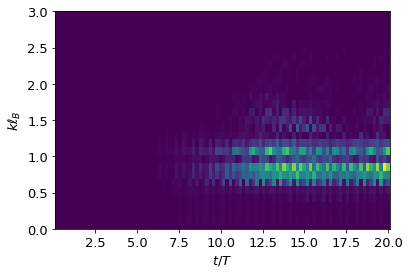

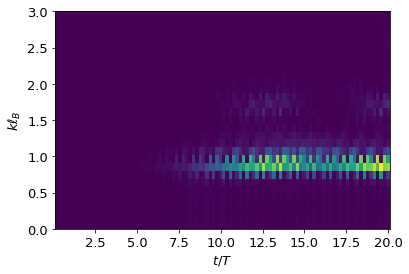

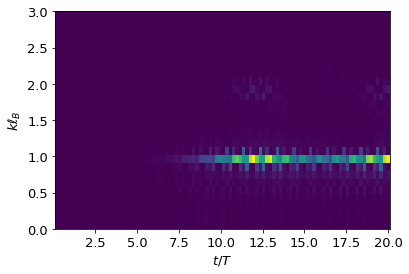

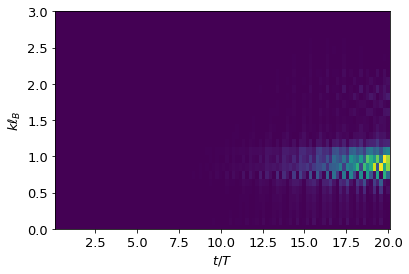

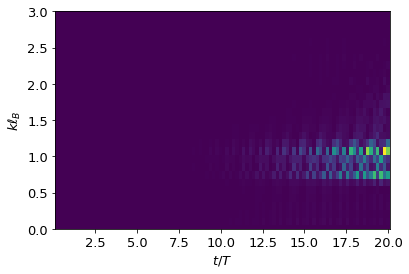

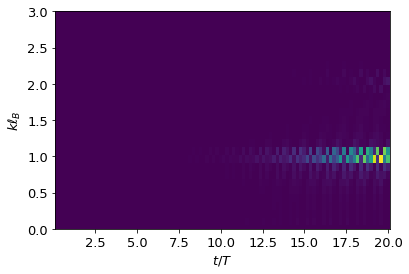

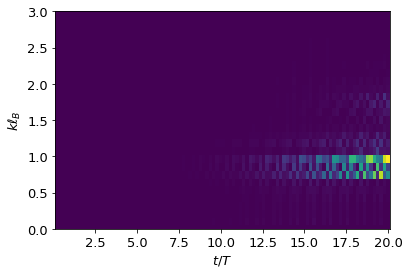

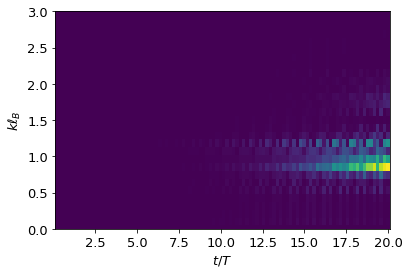

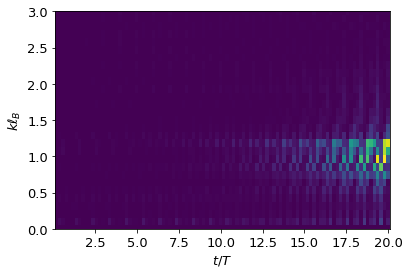

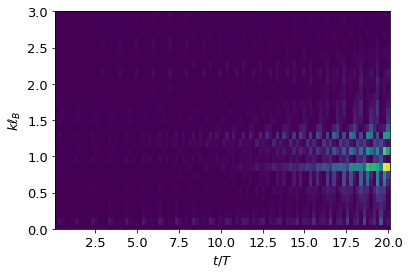

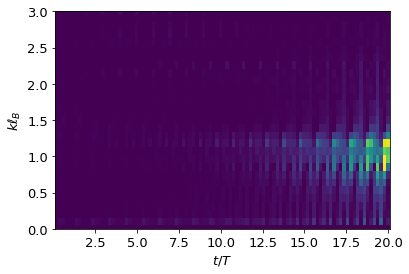

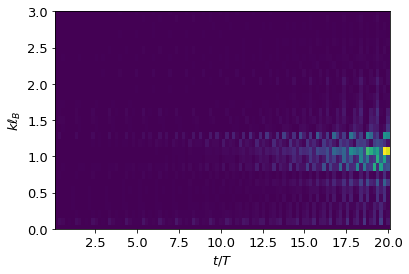

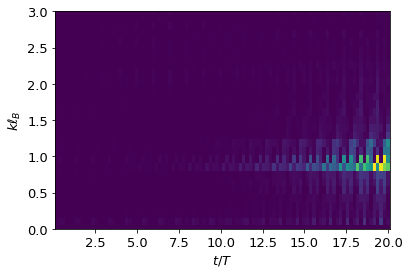

In [263]:
for i,r in growthdf.iterrows():
    plt.pcolormesh(times,klb,np.transpose(r.sk[1:]), shading='auto')
    plt.ylim([0,3])
    plt.xlabel('$t/T$')
    plt.ylabel('$k\ell_B$')
    plt.show()

## Old processing notes

In [136]:
dx = fov/DIM
window = 400
x  = dx * (np.arange(window) - window//2)
dk = 1/(window * dx)
k = dk * np.arange(window)
mass = 3.8e-26
lb = np.sqrt(hbar / (2*mass *omega))
klb = lb * k * (2*np.pi)

def process_growth(psi, plot=False):
    density = (np.abs(psi) ** 2) # need to check calibrations
    cloud = rotate_crop(density, viewx=window, viewy=window, angle=43)
    xprofile = np.sum(cloud, axis=0) 
    sk = np.abs(np.fft.fft(xprofile - np.mean(xprofile))) **2  / np.sum(xprofile)
#     gaussfit,_ = curve_fit(gauss, x, xprofile, [0, np.max(xprofile), 6e-6])
    if plot: 
        f,a = plt.subplots(figsize=(12,8),ncols=3)
        a[0].imshow(np.rot90(cloud))
        a[1].plot(1e6*x,xprofile)
        a[1].set_aspect(1./a[1].get_data_ratio())
        a[2].plot(klb,sk)
        a[2].set(xlim = [0,3])
        a[2].set_aspect(1./a[2].get_data_ratio())
#         a[2].plot(x,gauss(x,*gaussfit))
        plt.tight_layout()
        plt.show()
    return sk

#fitting 

@np.vectorize
def coshfuncsat(t,rate,amp, tsat):
    return min(np.log(amp*np.cosh(2*rate*t)),np.log(amp*np.cosh(2*rate*tsat)))


def coshfunc(t,rate,amp):
    return np.log(amp*np.cosh(2*rate*t))

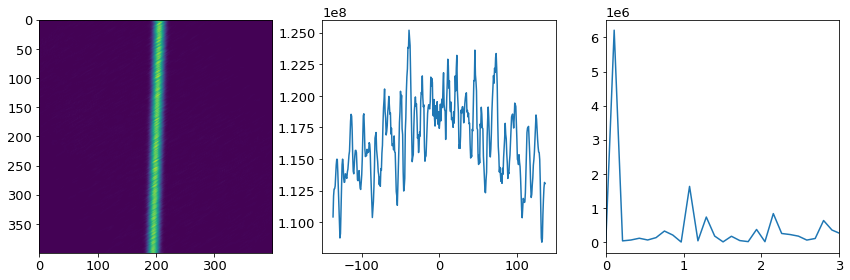

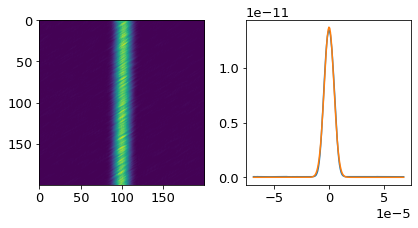

1.335212044194789


In [137]:
# tests with old data

with h5py.File('data/rotiniMovie.hdf5', 'r') as f:
    dset = f['rotini']
    i=6
    cloud = dset[i]
    sk = process_growth(cloud, plot=True)
    width = find_width(np.abs(cloud)**2, plot=True)
    print(np.sqrt(2) * width / lb)

In [287]:
# tests with old data
sks = []
with h5py.File('data/rotiniMovie.hdf5', 'r') as f:
    dset = f['rotini']
    times = dset.attrs['dt'] * np.cumsum(dset.attrs['times']) * omega / (2*np.pi)
    for i in tqdm(range(len(dset))):
        cloud = dset[i]
        sks.append(process_growth(cloud, plot=False))

In [288]:
select = np.arange(0,900,100)
clouds = []
with h5py.File('data/rotiniMovie.hdf5', 'r') as f:
    dset = f['rotini']
    for i in select:
        density = (np.abs(dset[i]) ** 2) # need to check calibrations
        cloud = rotate_crop(density, viewx=window, viewy=150, angle=45)
        clouds.append(cloud)
        


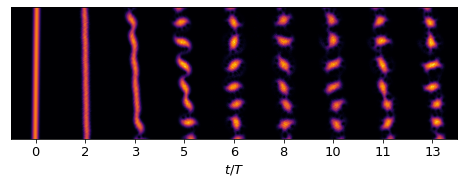

In [289]:
plt.subplots(figsize=(8,4))
plt.imshow(np.rot90(np.vstack(clouds)), cmap='inferno', vmin=0)
plt.yticks([])
plt.xticks(75+150*np.arange(len(select)), [f'{x:0.0f}' for x in times[select]])
plt.xlabel('$t/T$')
plt.show()

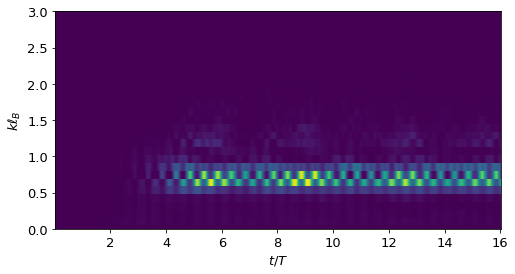

In [290]:
plt.subplots(figsize=(8,4))
plt.pcolormesh(times,klb,np.transpose(sks[1:]), shading='auto')
plt.ylim([0,3])
plt.xlabel('$t/T$')
plt.ylabel('$k\ell_B$')
plt.show()

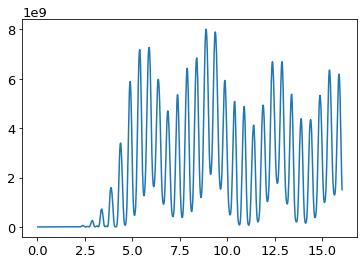

In [298]:
plt.plot(xs,np.array(sks)[1:,7])

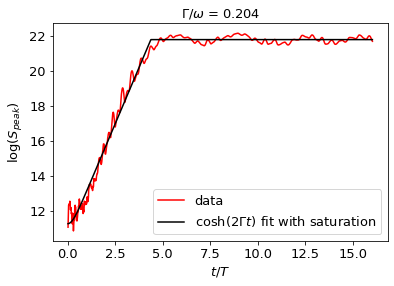

In [296]:
growth = np.mean(np.array(sks)[1:,6:9], axis=1)
xs = times
ys = np.log(growth)
guess= [1,200000,5]
plt.plot(xs,ys,'r', label='data')
# plt.plot(xs, coshfuncsat(xs,*guess))
f,e = curve_fit(coshfuncsat, xs, ys, guess)
plt.plot(xs, coshfuncsat(xs,*f),'k', label='$\cosh(2\Gamma t)$ fit with saturation')
plt.xlabel('$t/T$')
plt.ylabel('$\log(S_{peak})$')
plt.title(f'$\Gamma/\omega$ = {f[0]/(2*np.pi):.3f}')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


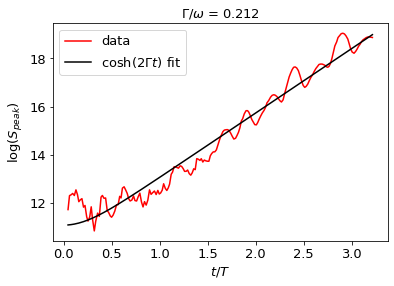

In [294]:
growth = np.mean(np.array(sks)[2:200,6:9], axis=1)
xs = times[2:200]
ys = np.log(growth)
guess= [1,200000]
plt.plot(xs,ys,'r', label='data')
# plt.plot(xs, coshfunc(xs,*guess))
f,e = curve_fit(coshfunc, xs, ys, guess)
plt.plot(xs, coshfunc(xs,*f),'k', label='$\cosh(2\Gamma t)$ fit')
plt.ylabel('$\log(S_{peak})$')
plt.title(f'$\Gamma/\omega$ = {f[0]/(2*np.pi):.3f}')
plt.xlabel('$t/T$')
plt.legend()
plt.show()

In [283]:
f[0]/(2*np.pi)

0.007925996963464917

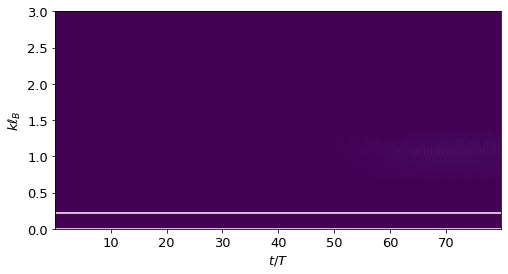

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


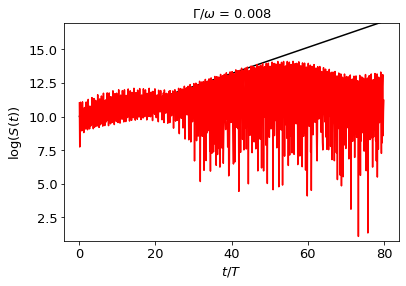

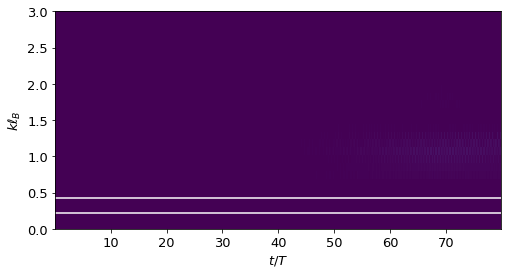

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


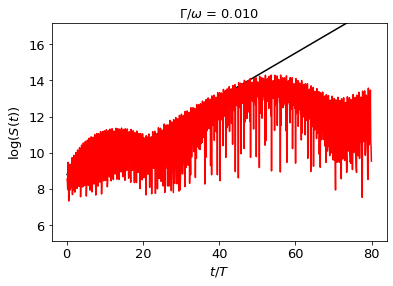

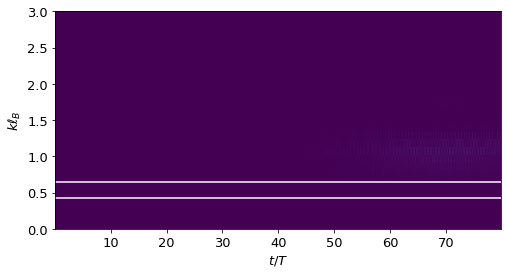

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


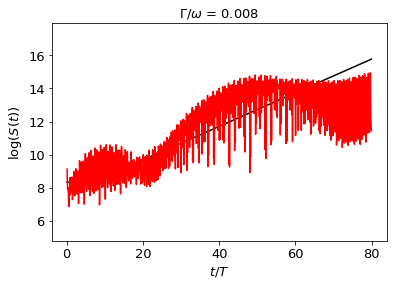

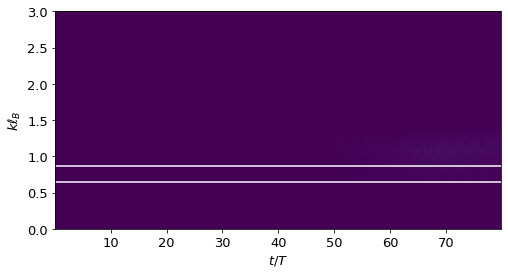

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


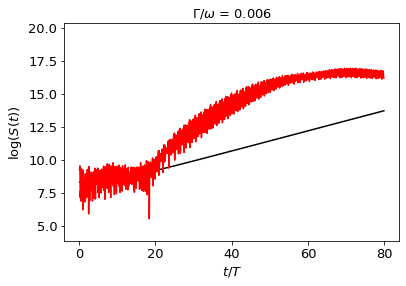

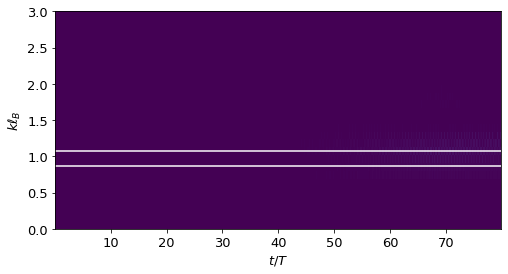

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


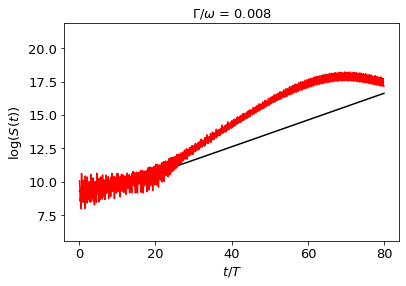

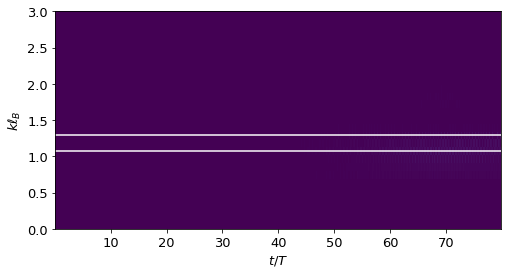

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


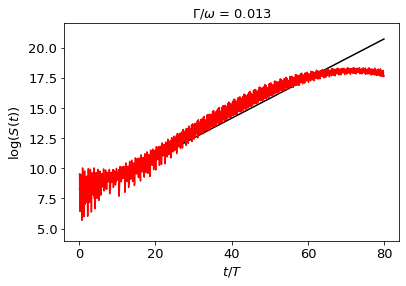

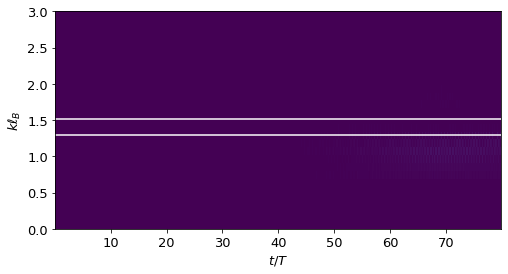

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


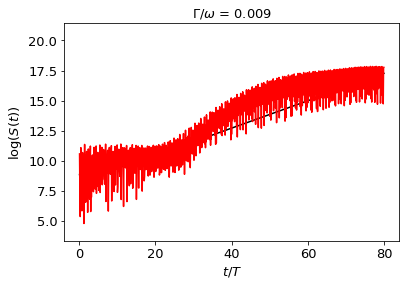

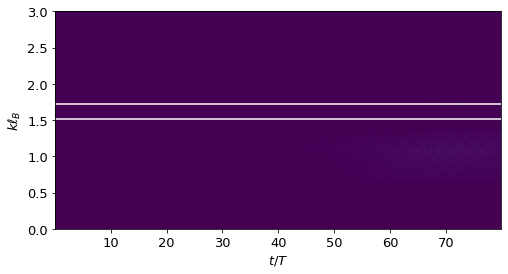

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


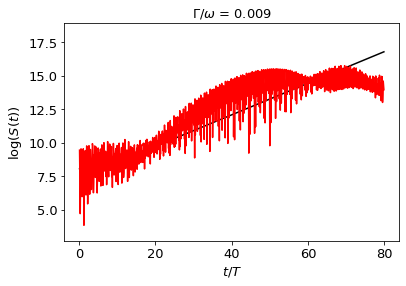

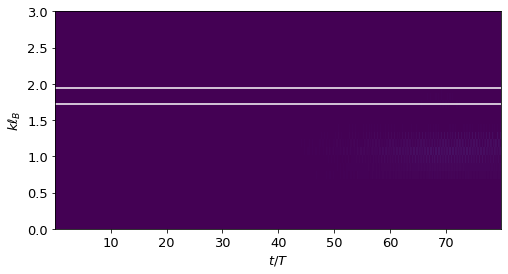

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


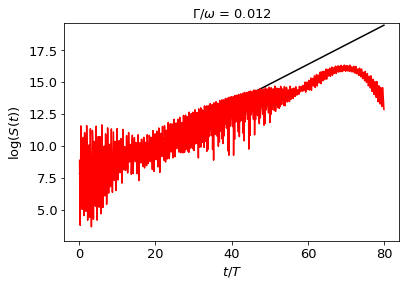

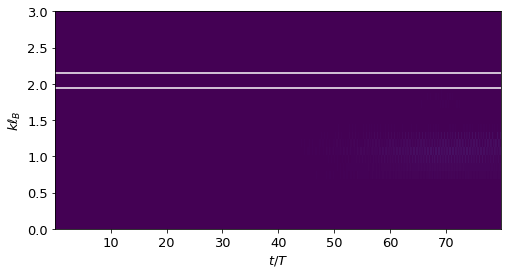

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


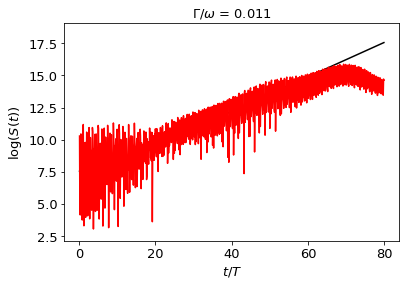

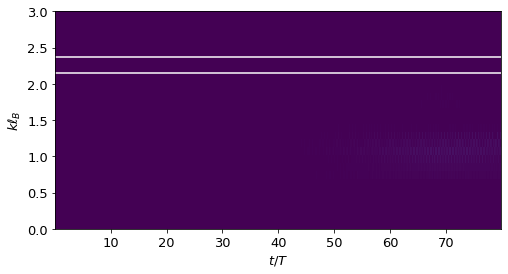

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


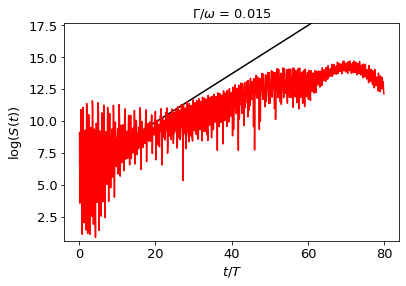

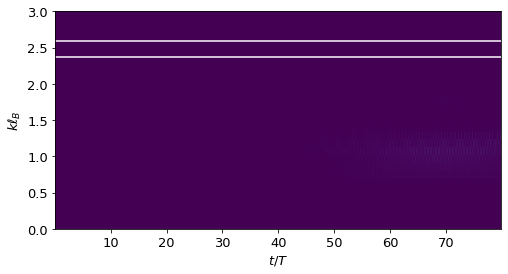

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


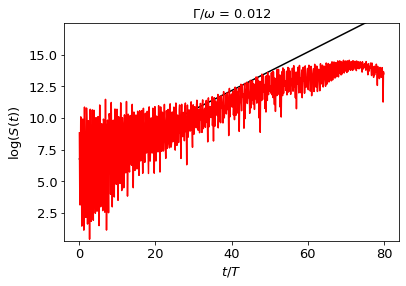

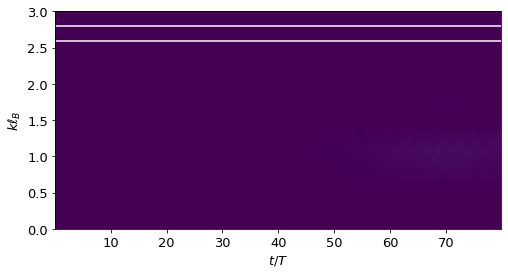

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


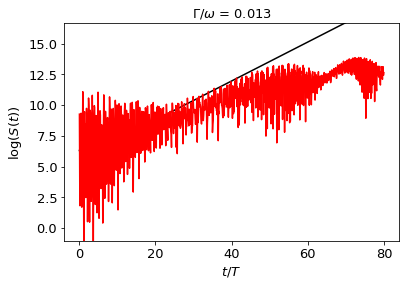

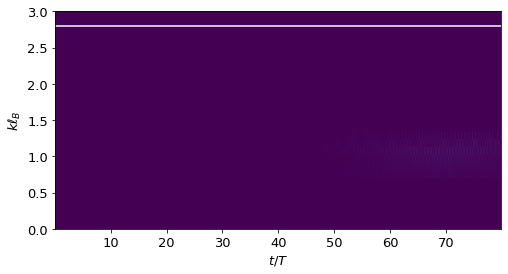

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


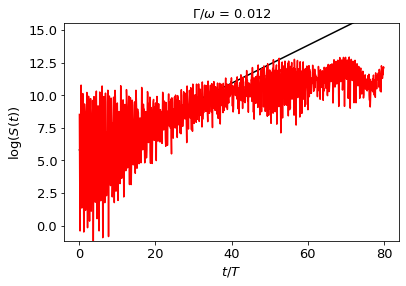

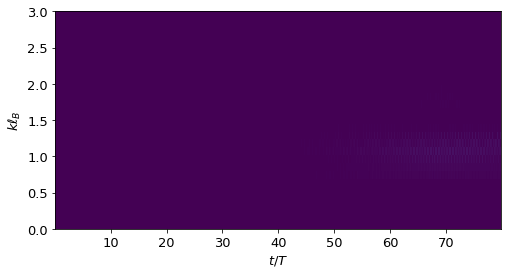

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


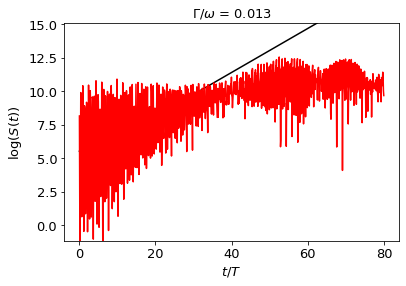

In [284]:
rates = []
raterrs = []
di=2

for i in range(0,30,di):
    
    plt.subplots(figsize=(8,4))
    plt.pcolormesh(times,klb,np.transpose(sks[1:]), shading='auto',  vmax=3e9)
    plt.ylim([0,3])
    plt.xlabel('$t/T$')
    plt.ylabel('$k\ell_B$')
    plt.axhline(klb[i],c='w')
    plt.axhline(klb[i+di],c='w')
    plt.show()
    
    growth = np.mean(np.array(sks)[1:,i:i+di], axis=1)
    xs = times
    ys = np.log(growth)
    
    guess= [1,200000]
    f,e = curve_fit(coshfunc, xs[:200], ys[:200], guess)
    plt.plot(xs, coshfunc(xs,*f),'k', label='$\cosh(2\Gamma t)$ fit')
    
#     guess= [1,200000,5]
#     f,e = curve_fit(coshfuncsat, xs, ys, guess)
#     plt.plot(xs, coshfuncsat(xs,*f),'k', label='$\cosh(2\Gamma t)$ fit with saturation')
    
    plt.plot(xs,ys,'r', label='data')
    plt.ylim([0.7*np.min(ys),1.2*np.max(ys)])
    plt.ylabel('$\log(S(t))$')
    plt.title(f'$\Gamma/\omega$ = {f[0]/(2*np.pi):.3f}')
    plt.xlabel('$t/T$')
    
#     plt.show()
    
    rates.append(f[0]/(2*np.pi))
    raterrs.append(np.sqrt(np.diag(e))[0]/(2*np.pi))
    

In [270]:
def genarray(string):
    string = re.sub('{|}| ','',string)
    elements = re.split(',',string)
    enums = []
    for e in elements:
        if '*^' in e:
            es = re.split('\*\^',e)
            enums.append(np.float(es[0]) * (10**np.float(es[1])))
        else:
            enums.append(np.float(e))
    ks = enums[::2]
    es = enums[1::2]
    return np.vstack([ks,es])

df = pd.read_csv('data/bdg/bdgdata.dat', sep='\t', header=None, names=['gn','width','mu','rawesq'])

df['esq'] = None
df['eimag'] = None
for i,r in df.iterrows():
    esq = genarray(r.rawesq)
    df.at[i,'esq']= esq
    df.at[i,'eimag'] = np.vstack([esq[0],[np.sqrt(-e) if e<0 else np.nan for e in esq[1]]])

In [271]:
df.iloc[21]

gn                                                     3.91
width                                               1.48866
mu                                                  1.73518
rawesq    {{0., -2.929243842362673*^-9}, {0.006694964158...
esq       [[0.0, 0.006694964158471861, 0.013389928316943...
eimag     [[0.0, 0.006694964158471861, 0.013389928316943...
Name: 21, dtype: object

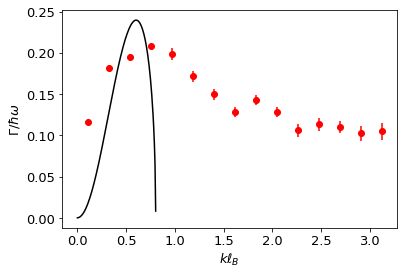

In [272]:
kxaxis = 0.5*(klb[np.arange(0,30,di)]+klb[np.arange(di,30+di,di)])
plt.errorbar(kxaxis,np.array(rates),yerr = raterrs,fmt='ro')

plt.plot(df.at[21,'eimag'][0],2*df.at[21,'eimag'][1],'k')

plt.ylabel('$\Gamma/\hbar\omega$')
plt.xlabel('$k\ell_B$')
plt.show()

# Data for ML

To run this section, reproduce the ground state and the hall strip from above. Use a 30000 ramp and a 10Hz trap

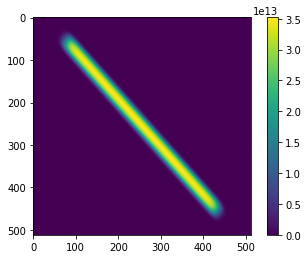

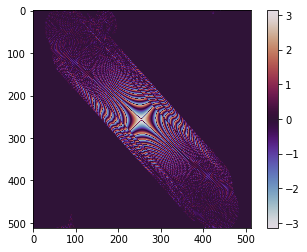

In [60]:
hallstrip.show_density()
hallstrip.show_phase()

In [61]:
# Set run parameters    
dt = 5e-5
noiseReps = 10
rotiniMLrun = pd.DataFrame()
rotiniMLrun['squeezeTime'] = [2000,3500, 5000,6500 ,8000, 10000,15000]
rotiniMLrun['runTime'] = [12000,14000, 15000 ,15000, 15000, 20000, 30000]

In [62]:
def runtimeFinder(runTime, numFrames, random=True):
    times = []
    basetime = runTime // numFrames
    times = [basetime] * numFrames
    if random: times = [t + int(np.random.normal(scale=basetime/10)) for t in times]
    return times


def noiseMaker(amp=0.15):
    noise = (0.j)*np.zeros((DIM,DIM))
    for i in range(DIM):
        for j in range(DIM):
            noise[i,j]= np.exp(amp * 1.j * 2*np.pi * (0.5-np.random.rand()))
    return noise


def compute_rotini_ML(startStrip, runTime=10000,
                   frames=7, noise=0.15, 
                   dsname='rotini', datafile='data/rotiniML.hdf5'):
    
    rotini = deepcopy(startStrip)
    rotini.env.harmonic_potential(omega=omega, epsilon=0.0)
    out = []
    out.append(rotini.Psi.copy())
    times = runtimeFinder(runTime, frames)
    
    for steps in tqdm(times, leave=False):
        rotini.env.rotating_frame(omegaR=[omega]*steps)
        rotini.evolve(steps=steps, cooling=0.0, dt=dt)
        out.append(rotini.Psi.copy())
                
    with h5py.File(datafile, 'a') as f:
        dset = f.create_dataset(dsname, data=np.array(out))
        dset.attrs['times'] = times
        dset.attrs['dt'] = dt

In [63]:
for i, r in tqdm(rotiniMLrun.iterrows(), leave=True):
    squeezeStrip = deepcopy(hallstrip)
    steps = r.squeezeTime
    squeezeStrip.env.rotating_frame(omegaR=omega*np.ones(steps))
    squeezeStrip.evolve(steps=steps, cooling=0.0, dt=2e-5) 
    
    for i in tqdm(range(noiseReps), leave=False):
        startStrip = deepcopy(squeezeStrip)
        startStrip.Psi *= noiseMaker()
        compute_rotini_ML(startStrip=startStrip, runTime=r.runTime, frames=10,
                          dsname=f'rotini_{steps}_{i}')
    

## rotate and clean

In [5]:

def clean_rotini(img):


In [149]:

viewx=356
viewy=356
with h5py.File('data/rotiniML.hdf5', 'r') as f:
    names = [name for name in f]
    print(names[20])
    dset = f[names[20]]
    clouds = dset[()]
#     for name in tqdm(f):
#         dset=f[name]
#         clouds = dset[()]
# #         clouds = [rotate_crop(a, viewx, viewy, 42) for a in dset[()]]
#         break

rotini_2000_0


In [150]:
rotini = clouds[8]

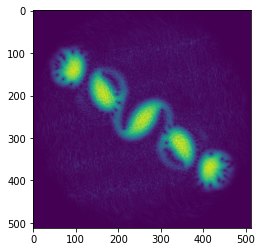

In [151]:
plt.imshow(np.abs(rotini))

In [161]:
def getimage(psi):
    psi = psi.copy()
    psi = psi[::2,::2]
    n = np.abs(psi)**2
    nimg = [255*n/n.max(),255*n/n.max(),255*n/n.max()]
    rg = np.array([np.real(psi), np.imag(psi),0*np.real(psi)])
    phiimg = 255*(rg+np.max(np.real(psi)))/(2.4*np.max(np.real(psi)))
    allimg = np.hstack([nimg,phiimg]).T
    return Image.fromarray(np.uint8(allimg))

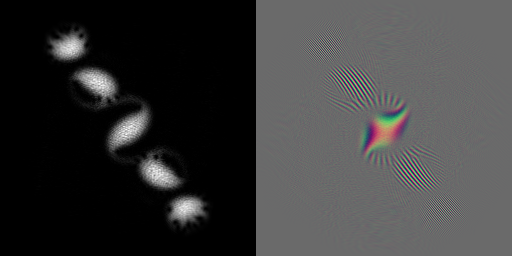

In [162]:
getimage(rotini* np.exp(13j * phase))
getimage(rotini)

In [105]:
with h5py.File('data/rotiniML.hdf5', 'r') as f:
#     names = [name for name in f]
#     print(names[20])
#     dset = f[names[20]]
    for name in tqdm(f):
        dset = f[name]
        for i in tqdm(range(len(dset)), leave=False):
            cloud = dset[i]
            im = getimage(cloud)
            im.save('data/rotiniML/'+name+str(i)+'.jpg')
    

        
            
        
        
    

In [128]:
imfake = Image.open('data/rotiniMLoutput/rotini_5000_30_fake_B.png')
imreal = Image.open('data/rotiniMLoutput/rotini_5000_30_real_B.png')
imn = Image.open('data/rotiniMLoutput/rotini_5000_30_real_A.png')

In [146]:
fakearray = np.array(imfake)
realarray = np.array(imreal)

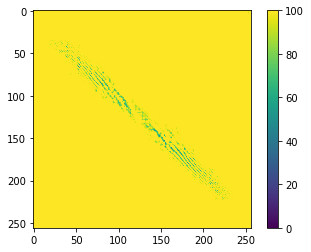

In [145]:
plt.imshow(fakearray[:,:,2], vmax=100, vmin=0)
plt.colorbar()

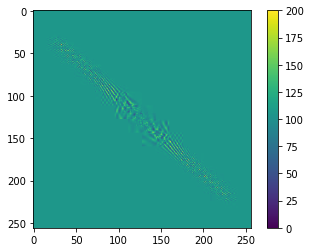

In [148]:
plt.imshow(realarray[:,:,2], vmax=200, vmin=0)
plt.colorbar()

In [153]:
imtest = getimage(rotini)

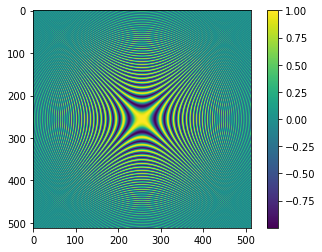

In [19]:
x = np.linspace(-5,5,DIM)
xx, yy = np.meshgrid(x, x)
 
# phase = xx * yy
phase = (xx + yy)*(xx- yy)
# phase = np.arctan(yy/xx)

plt.imshow(np.exp(9j * phase).real)
plt.colorbar()

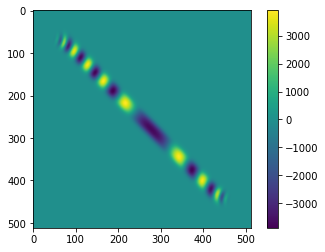

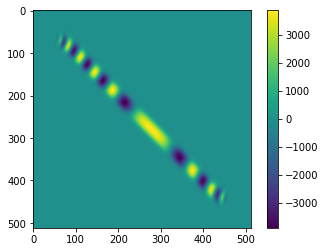

In [21]:
test= rotini.Psi * np.exp(14j * phase)
plt.figure()
plt.imshow(test.real)
plt.colorbar()
test2= rotini.Psi * np.exp(14j * phase) * np.exp(0j*phase + 3j)
plt.figure()
plt.imshow(test2.real)
plt.colorbar()

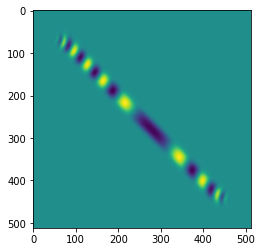

In [22]:
plt.imshow(test.real - test2.real)

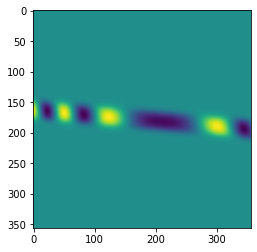

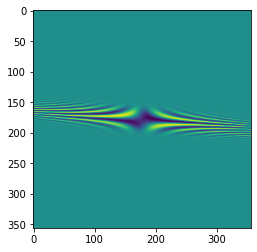

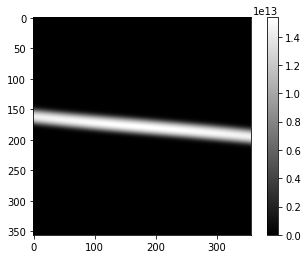

In [23]:
plt.imshow(rotate_crop(test.real, viewx=356, viewy=356, angle=40))
plt.show()
plt.imshow(rotate_crop(rotini.Psi.real, viewx=356, viewy=356, angle=40))
plt.show()
plt.imshow(rotate_crop(rotini.density, viewx=356, viewy=356, angle=40), cmap='gist_gray')
plt.colorbar()

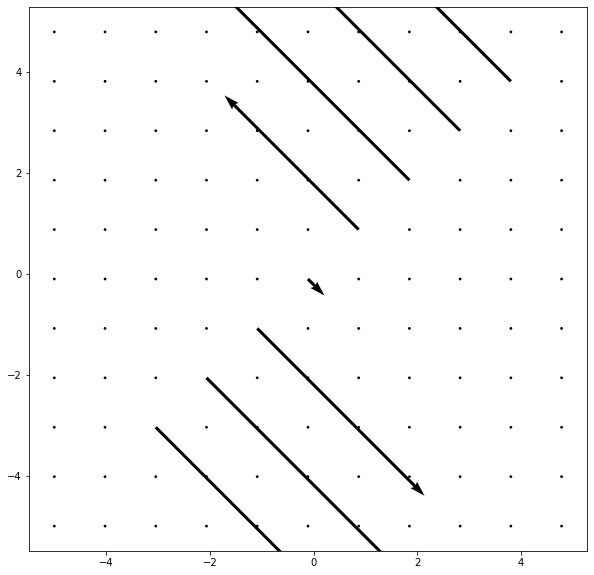

In [63]:
vx, vy = np.gradient(phase*(np.abs(test)>5e2))
skip=50
plt.figure(figsize=(10,10))
plt.quiver(xx[::skip,::skip],yy[::skip,::skip],vx[::skip,::skip],vy[::skip,::skip])

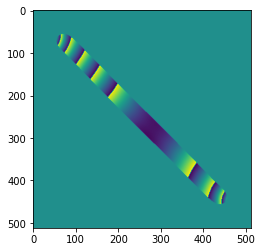

In [25]:
plt.imshow(np.angle(test)* (np.abs(test)>5e2))

In [42]:
alal = [np.linalg.norm([vxx,vyy]) for (vxx,vyy) in zip(vx.flatten(), vy.flatten())]

In [46]:
alal= (vy-vy2).flatten()

(0.0, 1000.0)

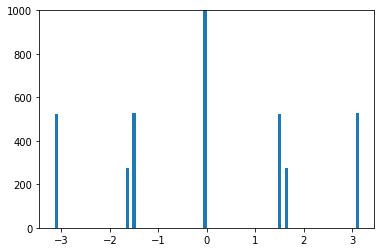

In [47]:
plt.hist(alal, bins=90)
plt.ylim([0,1000])

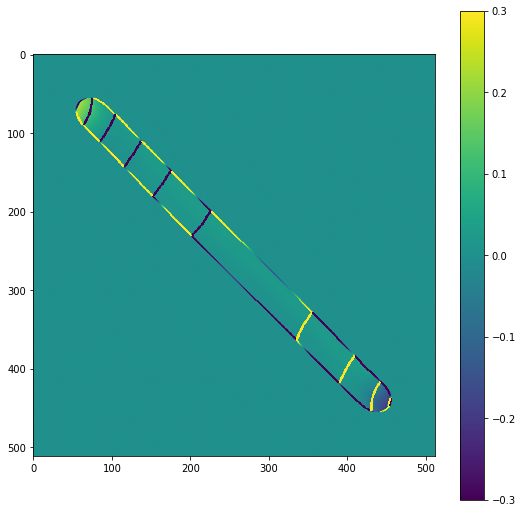

In [65]:
plt.figure(figsize=(9,9))
plt.imshow(vy-vy2, vmin=-.3,vmax=.3)
plt.colorbar()

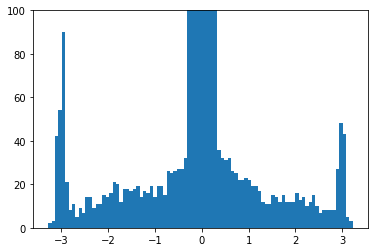

In [69]:
plt.hist((vx-vx2).flatten(), bins=90)
plt.ylim([0,100])
plt.show()

In [ ]:
vx2, vy2 = np.gradient(np.angle(test2)*(np.abs(test2)>5e2))

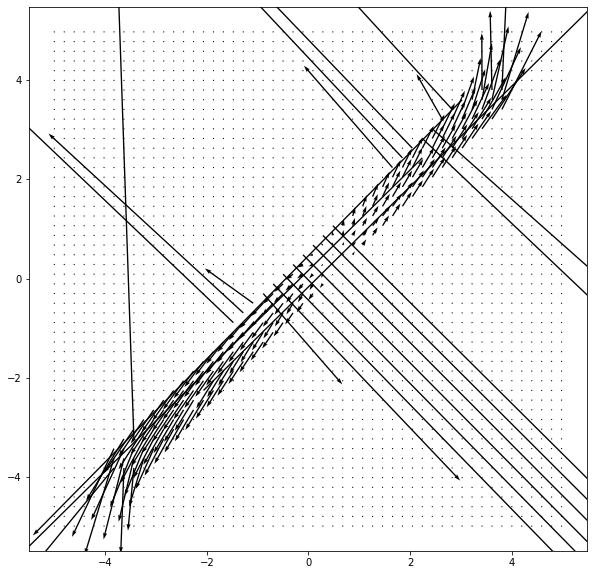

In [59]:
vx, vy = np.gradient(np.angle(test)*(np.abs(test)>5e2))
skip=10
plt.figure(figsize=(10,10))
plt.quiver(xx[::skip,::skip],yy[::skip,::skip],vx[::skip,::skip],vy[::skip,::skip])

# Reproducing lab parameters


            Running condensate on 512x512 grid with:
            atom number: 8e+05 
            mass:        3.80e-26
        


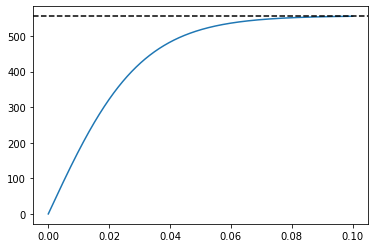

In [2]:
omega   = 2*np.pi*88.6
epsilon = 0.2
dt = 1e-6

e = Environment(DIM=512, fov=120e-6, N=8e5)
e.harmonic_potential(omega=omega, epsilon=epsilon)

groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=1e9, dt=2*dt, steps=4000)
groundstate.evolve(dt=dt, cooling=0.01, steps=4000)

whirrMax = omega
steps = 100000
whirrtime = 100000
times = np.arange(steps)
Omega = [np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * t / whirrtime)]) for t in times]
plt.plot(dt*times, Omega)
plt.axhline(Omega[-1],ls='--',c='k')
plt.show()


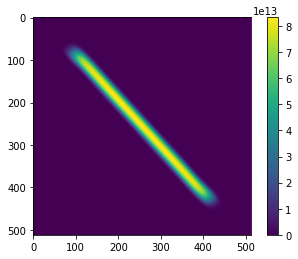

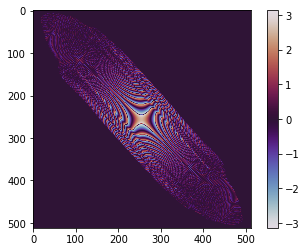

In [3]:
# Run the sim - takes longer than the 10Hz sim above
hallstrip = deepcopy(groundstate)
hallenv = hallstrip.env
hallenv.rotating_frame(omegaR=Omega)
hallenv.absorbing_boundaries(strength=1, radius=e.fov/2)

hallstrip.evolve(dt=dt, steps=steps, cooling=0)
hallstrip.show_density()
hallstrip.show_phase()

In [4]:
finalstrip = deepcopy(hallstrip)

## Crop and find the angle to the diagonal after the ramp

In [10]:
width = 512//2
plotrange=140
ncrop = finalstrip.density[(width-plotrange):(width+plotrange),(width-plotrange):(width+plotrange)]

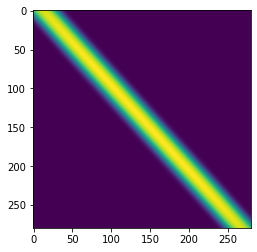

In [13]:
plt.imshow(ncrop)

In [20]:
xsize = len(ncrop)
xx = np.linspace(-10, 10, xsize)
yy = np.linspace(-10, 10, xsize)
xx, yy = np.meshgrid(xx, yy)

# Calculate the moment of inertia tensor
Ixx = np.sum(ncrop*yy*yy)
Iyy = np.sum(ncrop*xx*xx)
Ixy = np.sum(ncrop*xx*yy)
Iyx = Ixy
I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
evals, evecs = np.linalg.eig(I)
iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)


In [21]:
print(f"angle from diagonal equipotential: {(iangle-45):.2f} degrees")

angle from diagonal equipotential: 2.47 degrees
